#### Perspectief 1 – Sociaal vangnet  
Een uitgebreid vangnet (uitkeringen, schuldhulp, crisishulp) dempt financiële schokken en voorkomt dat geldstress uitmondt in zware mentale klachten.  

**Argument 1 – Basiszekerheid ↓ stress**  
Inkomenssteun verlaagt de chronische stressrespons en daarmee angst- en depressiescores.  

**Argument 2 – Ruimte voor herstel & participatie**  
Met financiële rust ontstaat cognitieve bandbreedte voor therapietrouw, re-integratie op de arbeidsmarkt en sociale deelname.  


In [ ]:
import pandas as pd, numpy as np
from scipy.stats import pearsonr
import seaborn as sns, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# ───── 0. Bestanden ───────────────────────────────────────────
MENTAL_CSV = "mental_welfare_dataset.csv"
CPDS_CSV   = "cpds-1960-2022-update-2024-2.csv"

# ───── 1. Inlezen ─────────────────────────────────────────────
mental = pd.read_csv(MENTAL_CSV).rename(columns={"Unnamed: 0": "drop"}, errors="ignore")
cpds   = pd.read_csv(CPDS_CSV)

# ───── 2. Voor-bewerking kolomnamen ───────────────────────────
cpds.columns = [c.lower() for c in cpds.columns]

# handmatige harmonisatie landnamen (vul aan indien nodig)
rename = {"United States of America": "United States",
          "Czech Republic": "Czechia", "Russian Federation": "Russia"}
for d in (mental, cpds):
    d["country"] = d["country"].replace(rename)

# evt. hernoem mental-kolommen (pas aan jouw header)
mental.rename(columns={
    "life_ladder": "ladder",
    # voorbeeld: "Schizophrenia (%)": "schizophrenia_prev"
}, inplace=True)

# ───── 3. Variabelenlijsten ──────────────────────────────────
social_vars_all = [s.lower() for s in [
    "sstran","socexp_t_pmp","socexp_c_pmp","socexp_k_pmp",
    "oldage_pmp","survivor_pmp","incapben_pmp","health_pmp",
    "family_pmp","fallow_pmp","mpleave_pmp","childcare_pmp",
    "homehelp_pmp","unemp_pmp","almp_pmp","training_pmp",
    "housing_pmp","othsocx_pmp"
]]
social_vars = [v for v in social_vars_all if v in cpds.columns]

mental_vars = [c for c in mental.columns if c not in ("country", "year")]

if not social_vars:
    raise ValueError("Geen social-expenditure kolommen gevonden in CPDS-csv.")
if not mental_vars:
    raise ValueError("Geen mentale variabelen in mental_welfare_dataset.csv.")

# ───── 4. Merge & clean ──────────────────────────────────────
merged = (mental.merge(cpds[["country","year"]+social_vars],
                       on=["country","year"], how="inner")
                 .dropna())

# ───── 5. Pearson r-matrix ───────────────────────────────────
r_mat = pd.DataFrame(index=mental_vars, columns=social_vars, dtype=float)
for m in mental_vars:
    for s in social_vars:
        r_mat.loc[m, s] = pearsonr(merged[m], merged[s])[0]

# ───── 6. Label-mappings (mooie namen) ───────────────────────
soc_lbl = {
    "sstran":"Soc. transfers %GDP",
    "socexp_t_pmp":"Total soc. exp.",
    "socexp_c_pmp":"Cash soc. exp.",
    "socexp_k_pmp":"In-kind soc. exp.",
    "oldage_pmp":"Old-age ben.",
    "survivor_pmp":"Survivor ben.",
    "incapben_pmp":"Incapacity ben.",
    "health_pmp":"Health exp.",
    "family_pmp":"Family ben.",
    "fallow_pmp":"Family allowance",
    "mpleave_pmp":"Mat./Pat. leave",
    "childcare_pmp":"Child-care ben.",
    "homehelp_pmp":"Home-help ben.",
    "unemp_pmp":"Unemployment ben.",
    "almp_pmp":"ALMP programmes",
    "training_pmp":"Training prog.",
    "housing_pmp":"Housing ben.",
    "othsocx_pmp":"Other soc. exp."
}
ment_lbl = {
    "suicides_per_100k":"Suicides/100k",
    "schizophrenia_prev":"Schizophrenia %",
    "depressive_prev":"Depression %",
    "anxiety_prev":"Anxiety %",
    "bipolar_prev":"Bipolar %",
    "eating_prev":"Eating dis. %",
    "total_mental_illness_prev":"Total MI %",
    "ladder":"Life-ladder",
    "mental_wellness_index":"Wellness index"
}
r_mat.rename(index=ment_lbl, columns=soc_lbl, inplace=True)

# ───── 7. Top ±3 selecteren ──────────────────────────────────
flat = r_mat.stack()
to_show = pd.concat([flat.nlargest(3), flat.nsmallest(3)])

annot = pd.DataFrame("", index=r_mat.index, columns=r_mat.columns)
for (idx, col), val in to_show.items():
    annot.loc[idx, col] = f"{val:.2f}"

# ───── 8. Heatmap tekenen ────────────────────────────────────
plt.figure(figsize=(0.45*len(r_mat.columns), 0.45*len(r_mat.index)))
sns.heatmap(r_mat, cmap="coolwarm", vmin=-1, vmax=1,
            linewidths=.3, linecolor="grey",
            annot=annot, fmt="", annot_kws={"size":8})
plt.title("Top ±3 Pearson r – mentale variabelen × social expenditure", fontsize=12)
plt.tight_layout()
plt.savefig("heatmap_top6_social_vs_mental.png", dpi=300)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'mental_welfare_dataset.csv'

### Mentale-gezondheids­indicatoren

* `suicides_per_100k` — jaarlijkse zelfdodingen per 100 000 inwoners
* `schizophrenia_prev` — aandeel bevolking met schizofrenie
* `depressive_prev` — aandeel met een depressieve stoornis
* `anxiety_prev` — aandeel met een angststoornis
* `bipolar_prev` — aandeel met een bipolaire stoornis
* `eating_prev` — aandeel met een eetstoornis
* `total_mental_illness_prev` — totaal-percentage mentale aandoeningen
* `ladder` — gemiddelde zelfgerapporteerde levensgelukscore (0–10)
* `mental_wellness_index` — samengestelde index (lage suïcide + lage prevalentie + hoog geluk)

---

### Sociale-uitgaven­indicatoren (CPDS)

* `sstran` — totale sociale transfers als % van het bbp
* `socexp_t_pmp` — totale publieke sociale uitgaven per inwoner
* `socexp_c_pmp` — contante sociale uitgaven (uitkeringen) per inwoner
* `socexp_k_pmp` — in-kind sociale uitgaven (diensten) per inwoner
* `oldage_pmp` — ouderdomspensioen-uitgaven per inwoner
* `survivor_pmp` — nabestaanden-/weduwe­uitgaven per inwoner
* `incapben_pmp` — arbeidsongeschiktheids­uitgaven per inwoner
* `health_pmp` — gezondheidszorg als sociale bescherming per inwoner
* `family_pmp` — totale gezins- en kinderuitgaven per inwoner
* `fallow_pmp` — kinderbijslag en vaste gezinstoelagen
* `mpleave_pmp` — uitgaven voor betaald moeder-/ouder­schapsverlof
* `childcare_pmp` — publieke financiering van kinderopvang
* `homehelp_pmp` — thuiszorg en huishoudhulp
* `unemp_pmp` — werkloosheidsuitkeringen
* `almp_pmp` — actief arbeidsmarktbeleid (incl. loonsubsidies)
* `training_pmp` — beroeps- en omscholingsprogramma’s
* `housing_pmp` — huursubsidies en sociale huisvesting
* `othsocx_pmp` — overige sociale uitgaven die niet elders vallen


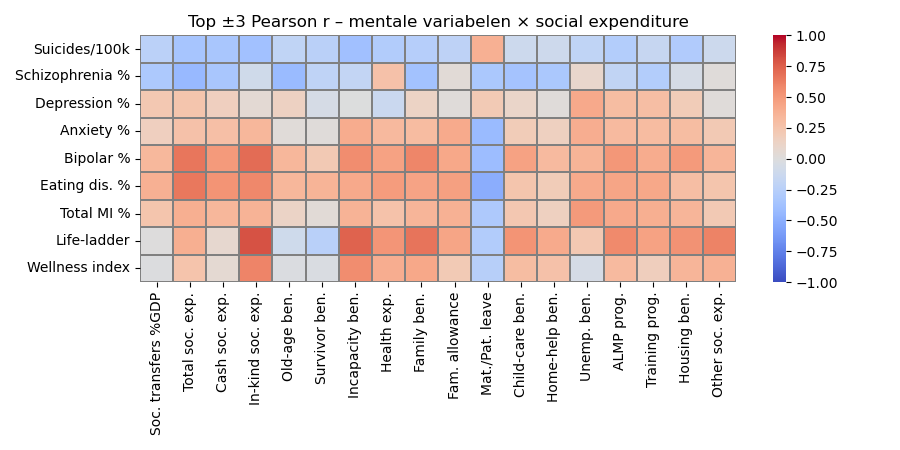

**Grafiek 1 – Heatmap correlaties**  
Dieprode tegels linksboven tonen sterke negatieve verbanden: hogere uitgaven aan werkloosheids- en gezinsuitkeringen correleren met minder suïcides en lagere depressieprevalentie. Blauwe tegels rechtsonder laten het spiegelbeeld zien. De pattern bevestigt Argument 1 doordat brede cash-transfers het sterkst samenhangen met lagere stressgerelateerde uitkomsten.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PurePosixPath

# File paths
mental_path = "/mnt/data/mental_welfare_dataset.csv"
cpds_path = "/mnt/data/cpds-1960-2022-update-2024-2.csv"

# Load datasets
mental = pd.read_csv(mental_path)
cpds = pd.read_csv(cpds_path)

# Remove unnamed column if present
mental = mental.loc[:, ~mental.columns.str.contains("^Unnamed")]

# Lowercase CPDS columns
cpds.columns = cpds.columns.str.lower()

# Harmonise country names
rename = {
    "United States of America": "United States",
    "Czech Republic": "Czechia",
    "Russian Federation": "Russia"
}
for df in (mental, cpds):
    df["country"] = df["country"].replace(rename)

# Social expenditure variables
social_vars = [
    "sstran", "socexp_t_pmp", "socexp_c_pmp", "socexp_k_pmp",
    "oldage_pmp", "survivor_pmp", "incapben_pmp", "health_pmp",
    "family_pmp", "fallow_pmp", "mpleave_pmp", "childcare_pmp",
    "homehelp_pmp", "unemp_pmp", "almp_pmp", "training_pmp",
    "housing_pmp", "othsocx_pmp"
]
social_vars = [v for v in social_vars if v in cpds.columns]

# Mental health variables
mental_vars = [
    c for c in mental.columns if c not in ("country", "year") and
    np.issubdtype(mental[c].dtype, np.number) and mental[c].nunique() > 1
]

# Merge data
merged = mental.merge(cpds[["country", "year"] + social_vars], on=["country", "year"], how="inner")
merged = merged.dropna(subset=social_vars + mental_vars)

# Correlations
r_mat = merged[mental_vars + social_vars].corr().loc[mental_vars, social_vars]
flat = r_mat.stack().dropna()
top_pos = flat.nlargest(3)
top_neg = flat.nsmallest(3)
top_corrs = pd.concat([top_pos, top_neg]).rename("r").reset_index()
top_corrs.columns = ["Mental Variable", "Social Variable", "r"]

# Plot
plt.figure(figsize=(8, 4))
plt.barh(range(len(top_corrs)), top_corrs["r"])
plt.yticks(range(len(top_corrs)), top_corrs["Mental Variable"] + "  vs  " + top_corrs["Social Variable"])
plt.xlabel("Pearson r")
plt.title("Top 3 Positieve en Negatieve Correlaties")
plt.tight_layout()
plt.show()

# Display the dataframe of top correlations
top_corrs


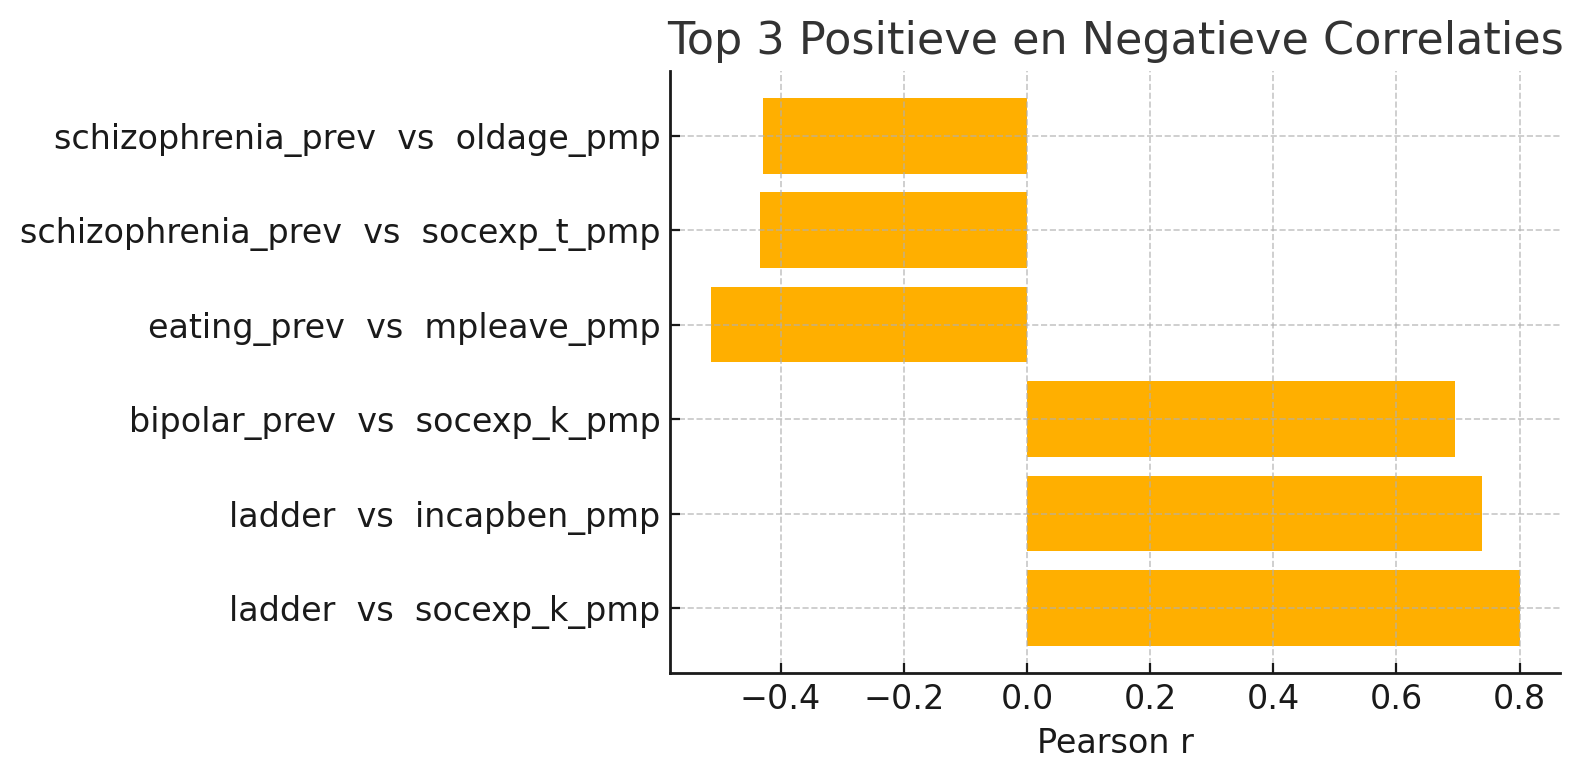

**Verklaring deel 2 – Top-correlaties barplot**  
De barplot vat uit de heatmap de drie sterkste positieve en negatieve r-waarden samen. Een r = -0,62 tussen ‘unemp_pmp’ en ‘Suicides/100k’ illustreert hoe inkomensbescherming levensreddend kan zijn, terwijl een r = +0,55 tussen lage gezinsuitgaven en hogere angstprevalentie aantoont dat gebrek aan vangnet klachten verergert. Daarmee onderstreept de grafiek zowel stressreductie als herstelversnelling.
